<a href="https://colab.research.google.com/github/ShiningYang0207/ECE661_final_project/blob/main/Super_Resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/ECE 661/ECE 661 final project/robustness_applications/')

In [ ]:
%cd drive

/content/drive


In [ ]:
%cd MyDrive/ECE\ 661\ final\ project

/content/drive/.shortcut-targets-by-id/1s7c6Z5jJyUtimJ5tJntlT762pMW9e0xT/ECE 661 final project


In [ ]:
%cd robustness_applications/

/content/drive/.shortcut-targets-by-id/1s7c6Z5jJyUtimJ5tJntlT762pMW9e0xT/ECE 661 final project/robustness_applications


In [ ]:
# install the requirements files
!pip install -r "/content/drive/MyDrive/ECE 661 final project/robustness_applications/requirements.txt"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 5.1 MB/s 
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7409 sha256=862cccbf345566a0f098364a4c8e39960439a7758404c1412828bf0997b618a7
  Stored in directory: /root/.cache/pip/wheels/ba/03/bb/7a97840eb54479b328672e15a536e49dc60da200fb21564d53
Successfully built GPUtil


In [ ]:
!pip install cox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 5.0 MB/s 
     |████████████████████████████████| 55 kB 5.1 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 


In [ ]:
import os
os.environ['NOTEBOOK_MODE'] = '1'
import sys
import torch as ch
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import seaborn as sns
from scipy import stats
from skimage.transform import resize
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from robustness import model_utils, datasets
from robustness.tools.vis_tools import show_image_row, show_image_column
from robustness.tools.label_maps import CLASS_DICT
from user_constants import DATA_PATH_DICT
%matplotlib inline

device = "cuda" if ch.cuda.is_available() else "cpu"

In [ ]:
# Constants
DATA = 'ImageNet' # Choices: ['RestrictedImageNet']
BATCH_SIZE = 10
NUM_WORKERS = 8
SR_FACTOR_RIN = 8

DATA_SHAPE = 32 if DATA == 'CIFAR' else 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)
CLASSES = CLASS_DICT[DATA] # Class names for dataset
NUM_CLASSES = len(CLASSES) - 1

NameError: ignored

In [ ]:
# Load dataset
import torchvision
from torchvision import transforms

transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
dataset_function = getattr(datasets, DATA)
imagenet_data = torchvision.datasets.ImageFolder(root="dataset/val", transform=transform)
test_loader = ch.utils.data.DataLoader(imagenet_data,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=NUM_WORKERS)
# dataset = dataset_function(DATA_PATH_DICT[DATA])
# _, test_loader = dataset.make_loaders(workers=NUM_WORKERS, 
#                                       batch_size=BATCH_SIZE, 
#                                       data_aug=False)
data_iterator = enumerate(test_loader)




In [ ]:
checkpoint = ch.load('models/ImageNet.pt')

In [ ]:
import re
modelWeights = {}
for k,v in checkpoint['model'].items():
  if re.match("module\.model[a-z0-9.]*", k):
    newKey = k.split("module.model.")[1]
    modelWeights[newKey] = v

In [ ]:
# PGD Parameters
# kwargs = {
#         # 'constraint':'2',
#         # 'eps': 8,
#         # 'step_size': 1,
#         'iterations': 40,
#         'targeted': True,
#         'should_normalize': True

# }

In [ ]:
# Load model
model = torchvision.models.resnet50()

In [ ]:
print(set(modelWeights.keys()).difference(set(model.state_dict().keys())))

set()


In [ ]:
model.load_state_dict(modelWeights)

<All keys matched successfully>

In [ ]:
def downsample(x, step=None):
    down = ch.zeros([len(x), 3, 224//step, 224//step])

    for i in range(0, 224, step):
        for j in range(0, 224, step):
            v = x[:, :, i:i+step, j:j+step].mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
            ii, jj = i // step, j // step
            down[:, :, ii:ii+1, jj:jj+1] = v
    return down

def upsample(x, step=None):
    up = ch.zeros([len(x), 3, 224, 224])
    for i in range(0, 224, step):
        for j in range(0, 224, step):
            ii, jj = i // step, j // step
            up[:, :, i:i+step, j:j+step] = x[:, :, ii:ii+1, jj:jj+1]
    return up

In [ ]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Construct low-res images by downsampling
im_test = []
targ_test = []
while len(targ_test) < 10:
  _, (img_rin, targ_rin) = next(enumerate(test_loader))
  if targ_rin.numpy()[0] not in targ_test:
    im_test.append(img_rin)
    targ_test.append(targ_rin)
    print(targ_test)
img_rin, targ_rin = ch.cat(im_test), ch.cat(targ_test)
img_lr = upsample(downsample(img_rin, step=SR_FACTOR_RIN), step=SR_FACTOR_RIN)

[tensor([3])]
[tensor([3]), tensor([1])]
[tensor([3]), tensor([1]), tensor([8])]
[tensor([3]), tensor([1]), tensor([8]), tensor([4])]
[tensor([3]), tensor([1]), tensor([8]), tensor([4]), tensor([7])]
[tensor([3]), tensor([1]), tensor([8]), tensor([4]), tensor([7]), tensor([5])]
[tensor([3]), tensor([1]), tensor([8]), tensor([4]), tensor([7]), tensor([5]), tensor([0])]
[tensor([3]), tensor([1]), tensor([8]), tensor([4]), tensor([7]), tensor([5]), tensor([0]), tensor([6])]
[tensor([3]), tensor([1]), tensor([8]), tensor([4]), tensor([7]), tensor([5]), tensor([0]), tensor([6]), tensor([9])]
[tensor([3]), tensor([1]), tensor([8]), tensor([4]), tensor([7]), tensor([5]), tensor([0]), tensor([6]), tensor([9]), tensor([2])]


In [ ]:
## Remap Labels
label_mapping = {
    -1 : -1,
    0 : 0,
    1 : 217,
    2 : 482,
    3 : 491,
    4 : 497,
    5 : 566,
    6 : 569,
    7 : 571,
    8 : 574,
    9 : 701,

}
targ_rin = targ_rin.numpy()
for i in range(0, len(targ_rin)):
  targ_rin[i] = label_mapping[targ_rin[i]]
targ_rin = ch.tensor(targ_rin)

In [ ]:
# PGD Parameters
kwargs = {
        'constraint':'2',
        'eps': 8,
        'step_size': 1,
        'iterations': 40,
        'targeted': True,
        'should_normalize': True

}



In [ ]:
from robustness.tools.helpers import InputNormalize
import scipy
class ModelWithNormalizer(ch.nn.Module):
    def __init__(self, m, n):
      super(ModelWithNormalizer, self).__init__()
      self.model= m
      self.normalizer = n
    
    def forward(self, x):
      return self.model(self.normalizer(x).float())
mean = ch.tensor(scipy.ndimage.mean(img_lr.numpy())).double()
std = ch.tensor(scipy.ndimage.standard_deviation(img_lr.numpy())).double()
normalizedModel = ModelWithNormalizer(model, InputNormalize(mean,std))

In [ ]:
sys.path.insert(0, '/content/drive/MyDrive/ECE 661 final project/robustness_applications')
import attacks_super_resolution as attacks
EPS= kwargs['eps']
ITS=kwargs['iterations']
ALPHA = kwargs['step_size']
img_sr = attacks.FGM_L2_attack(normalizedModel.to(device), device, img_lr.to(device), targ_rin.to(device), ALPHA, ITS)

In [ ]:
img_sr.cpu().numpy().transpose(0,2, 3, 1).shape

(10, 224, 224, 3)

In [ ]:
# Bicubic upsampling baseline
from PIL import Image
img_bicubic = np.stack([np.array(Image.fromarray(np.uint8(i.transpose(1, 2, 0)*255)).convert('RGB').resize((224,224),Image.BICUBIC))
                        for i in img_lr.numpy()])
img_bicubic = ch.tensor(img_bicubic.transpose(0,3,1,2)/255)

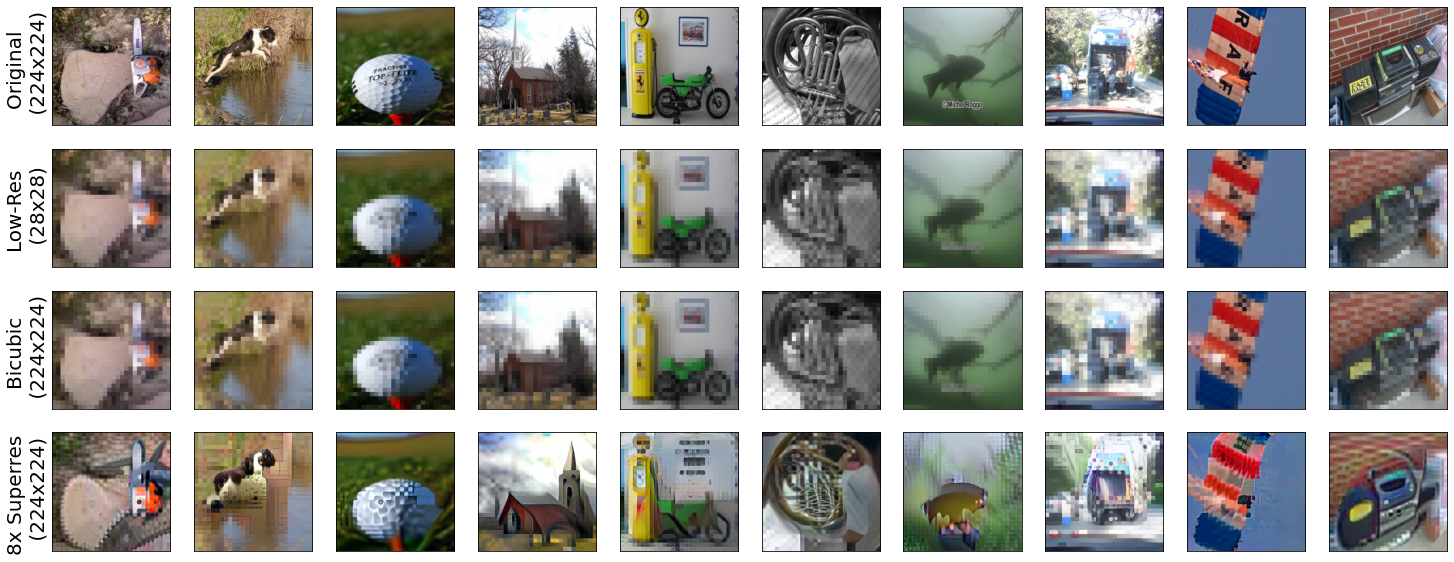

In [ ]:
# Visualize superres results
show_image_row([img_rin.cpu(), img_lr.cpu(), img_bicubic.cpu(), img_sr.detach().cpu()],
               ["Original \n (224x224)", "Low-Res \n (28x28)", "Bicubic \n (224x224)", "8x Superres \n (224x224)"],
               fontsize=20)